In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw
import math
import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/')
from tasks import inpainting
'''
Credits : https://github.com/JiahuiYu/generative_inpainting/blob/master/inpaint_ops.py#L126

'''

'\nCredits : https://github.com/JiahuiYu/generative_inpainting/blob/master/inpaint_ops.py#L126\n\n'

In [31]:
inpainter = inpainting(imgsize= 512, masksize= 256)

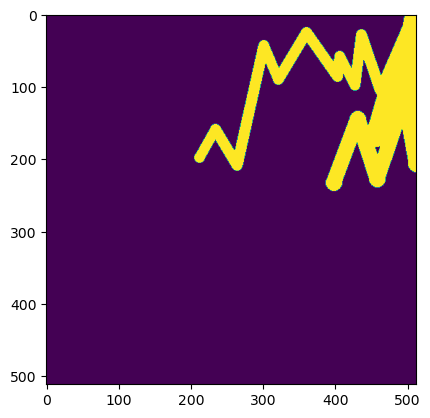

In [60]:
mask = inpainter.generate_stroke_mask()
plt.imshow(mask[0])

In [99]:
inpainter.generate_mask().shape

torch.Size([1, 256, 256])

In [102]:
[5] * 2

[5, 5]